# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [1]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


##Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer:

Given the descriptive statistics:

**Attribute: (Minimum, Maximum, Mean, Std. Deviation)**

- Fresh: ( 3, 112151, 12000.30, 12647.329)
- Milk: (55, 73498, 5796.27, 7380.377)
- Grocery: (3, 92780, 7951.28, 9503.163)
- Frozen: (25, 60869, 3071.93, 4854.673)
- Detergents_Paper: (3, 40827, 2881.49, 4767.854)
- Delicatessen: (3, 47943, 1524.87, 2820.106)

The _Fresh_ feature has the highest standard deviation and the largest range in values. Thus it might show up a PCA vector _pointing_ almost in that direction. Maybe it could also be among the first or second most important component.

From ICA I can expect some _buying pattern_. For example customers who buys more Milk and less Grocery might show up as an independent recurring pattern.

###PCA

In [2]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(n_components = 6)
pca.fit(data)

# Print the components and the amount of variance in the data contained in each dimension
print pca.components_
print pca.explained_variance_ratio_

[[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]
 [-0.17855726  0.50988675 -0.27578088  0.71420037 -0.20440987  0.28321747]
 [-0.04187648 -0.64564047  0.37546049  0.64629232  0.14938013 -0.02039579]
 [ 0.015986    0.20323566 -0.1602915   0.22018612  0.20793016 -0.91707659]
 [-0.01576316  0.03349187  0.41093894 -0.01328898 -0.87128428 -0.26541687]]
[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]


**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer: 

The first vector points towards a direction that explains 46% of the variance, and the second is along 40% of the variance in the data. The first two vectors will define a space in which 86% of the original data variance is retained.

In this case I would keep just the first two principal components. 
This will also help with data visualisation.

**3)** What do the dimensions seem to represent? How can you use this information?

Answer: 

The first component seems to heavily weight the first feature since its first coefficient is pretty close to |1|.
I would consider this as a vector that captures variations along the _Fresh_ feature.

The second component mainly combines _Milk_, _Grocery_ and _Detergents_Paper_. Also this component heavily penalize _Fresh_.
I would consider this component as the one that explains the variations among the important products except _Fresh_.

The third component considers _Frozen_ (`0.71`) but explains just 7% of the variations in the data.

_Delicatessen_ is significantly weighted at the fourth component which is along only 1.5% of the variance.

In the end I would consider two categories of products as important:
- _Fresh_
- _Milk_, _Grocery_ and _Detergents_Paper_

And the first two principal components as pointing along the directions of these two main groups.

_Frozen_ and _Delicatessen_ seems to be not much important in this case.


###ICA

In [3]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

centeredData = scaler.fit_transform(data)

ica = FastICA()
ica.fit_transform(centeredData)

# Print the independent components
print ica.components_

[[ 0.02231307 -0.12870728  0.69608367  0.01618815 -0.13473429 -0.09311566]
 [ 0.01885519  0.71838026 -0.55429378 -0.02025366  0.15656255 -0.28616189]
 [-0.04362731 -0.01629305 -0.05457412 -0.03142589  0.02088826  0.8671174 ]
 [ 0.44629259 -0.06676526 -0.07518563 -0.04041668  0.10129401 -0.04429337]
 [-0.09663211 -0.01075077  0.07211832  0.67824993 -0.02200013 -0.28561333]
 [ 0.02871967 -0.19390468 -1.05063588  0.09139899  1.13998156  0.27373151]]


In [4]:
# sort ICA components by the Fresh feature (changing the vector sign if Fresh coefficient is negative)
# sorting will help seeing if ICA is consistent among different runs
icaComponents = pd.DataFrame(ica.components_)
icaComponents.columns = data.columns.values
negativeFresh = icaComponents["Fresh"] < 0
icaComponents[negativeFresh] *= -1.0
icaComponents.sort_values(by=['Fresh'], ascending = [0], inplace=True)
icaComponentNames = ["IC 1", "IC 2", "IC 3", "IC 4", "IC 5", "IC 6"]
icaComponents.index = icaComponentNames

#print ica coefficients as % of the scaled features
icaComponents *= 100.
icaComponents

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
IC 1,44.629259,-6.676526,-7.518563,-4.041668,10.129401,-4.429337
IC 2,9.663211,1.075077,-7.211832,-67.824993,2.200013,28.561333
IC 3,4.362731,1.629305,5.457412,3.142589,-2.088826,-86.711740
IC 4,2.871967,-19.390468,-105.063588,9.139899,113.998156,27.373151
IC 5,2.231307,-12.870728,69.608367,1.618815,-13.473429,-9.311566
IC 6,1.885519,71.838026,-55.429378,-2.025366,15.656255,-28.616189


**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: 

Since the ICA algorithm seems to be pretty consistent among different runs, we can argue that there is some kind of customer behaviour pattern.

- IC 1: tells us that there is an independent component driven by the _Fresh_ products. A customer on this _line_ will have average spending on all the products except _Fresh_
- IC 2: is an independent component driven prevalently by _Frozen_ products with a negative correlation to _Delicatessen_. This _independent_ customer could by significantly more Frozen and 1/3 less Delicatessen with respect to the mean.
- IC 3: is an independent customer characterized by a strong difference in _Delicatessen_ spending.
- IC 4: tells us that there is an independent component of customers with a strong negative correlation between _Grocery_ and _Detergents Paper_. A customer on this line could buy way more Grocery and way less Detergents, or vice versa.
- IC 5: characterizes a customer driven by _Grocery_ spending, sligtly negatively correlated with _Milk_
- IC 6: characterizes a customer driven by _Milk_ spending negatively correlated by _Grocery_ and slightly negatively correlated with _Delicatessen_

The most interesting independent component is IC 4 since it clearly identify a _buying pattern_ with two products strongly correlated.


##Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

###Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: 

####K-Means
K-Means will linearly separate the clusters, in the sense that the boundaries between clusters are lines.
These are lines passing in the middle between every two centroids and orthogonal to the vector defined by centroids pair. Thus this algorithm always gives _sharp_ decision boundaries.
Clusters are formed with a strict topological criterion, since only the distance between sample and centroid is taken into account.
This algorithm is particularly good if, from our domain knowledge, we can say that _topological distance_ between samples is a significant clustering criterion.

Typically this algorithm will not always converge to the same final clusters. The final clusters will depend on the starting centroids. This algorithm is generally run more times in order to find what could be the best clusterization.

####Gaussian Mixture (Expectation Maximization)
This algorithm use a probabilistic approach. The centroids will be the centers of gaussian distributions. Every sample will be labeled with the centroid's distribution which most likely generated it.
This algorithm gives _soft_ boundaries. Boundaries defines how likely is that a sample is from a particular centroid.
Practically this algorithm always converge to the same clusterization.

####Model selection
Given that human behaviours always have some kind of random component, the Gaussian Mixture approach could be reasonable. Anyway it could bring to clusters with _overlapping_ areas, both having significant probabilistic likeleihood (more on this at the end of this document).
I will choose the K-Means approach in order to obtain _sharp_ cluster boundaries. In case this approach gives good results, it would be easier to comunicate and implement customers classification to the marketing area.



**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [5]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [6]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
reduced_data = PCA(n_components = 2).fit_transform(data)
print reduced_data[:10]  # print upto 10 elements

[[  -650.02212207   1585.51909007]
 [  4426.80497937   4042.45150884]
 [  4841.9987068    2578.762176  ]
 [  -990.34643689  -6279.80599663]
 [-10657.99873116  -2159.72581518]
 [  2765.96159271   -959.87072713]
 [   715.55089221  -2013.00226567]
 [  4474.58366697   1429.49697204]
 [  6712.09539718  -2205.90915598]
 [  4823.63435407  13480.55920489]]


In [7]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'

clusters = KMeans(n_clusters = 5)
clusters.fit(reduced_data)
print clusters

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)


In [8]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [9]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 

centroids = clusters.cluster_centers_
print centroids

[[ -9052.39957144  -4808.55909102]
 [  5607.91709853  14199.18040025]
 [-14537.71774395  61715.67085248]
 [  6399.7117556   -4169.29690862]
 [-37704.64157991  -5488.35405895]]


/Users/matteo/.graphlab/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


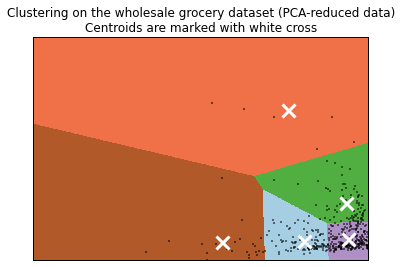

In [10]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

**A comparison with GMM and different number of clusters is described at the and of this document.**

**7)** What are the central objects in each cluster? Describe them as customers.

Answer: 
- **Low Spending**: Bottom Right Customers with low spending in both Fresh and Non-fresh products
- **Mid Spending, mostly Fresh**: First centroid at the left of _Low Spending_. These customer have significant spending and are characterized by a prevalence of _Fresh_ products.
- **Mid Spending, mostly Non-Fresh**: First centroid above _Low Spending_. These customers have significant spending and are characterized by a prevalence of _Non-Fresh_ products.
- **High Spending, mostly Fresh**: Centroid at the left of _Mid Spending, mostly Fresh_. These could be considered as important (loyal) customers interested in Fresh products.
- **High Spending, mostly Non-Fresh**: Above _Mid Spending, mostly Non-Fresh_. These could be considered as important (loyal) customers interested in Non-Fresh products.

In [11]:
# This will help evaluating the importance of each cluster based on its _population_
labeled = pd.DataFrame(clusters.predict(reduced_data))
labeled.stack().value_counts()

3    227
0    103
1     80
4     23
2      7
dtype: int64

_Low Spending_ customer cluster is the most populated one (200+). The second most populated cluster is _Mid Spending, mostly Fresh_ followed closely by _Mid Spending, mostly Non-Fresh_.
These are the relevant clusters obtained with this method.

The other two clusters are less meaningful and, in fact, overlaps. A high spending customer classified as _non-Fresh_ could have also the highest _Fresh_ spending. These two clusters could be collapsed in a single cluster labeled _High Spending_. Although _Fresh_ remains an important discriminant.
As we will see later GMM does a better job in identifying the _high spending_ cluster, but is not as good at clustering the low spending customers (which is the most populated).

This highlights the effect of K_Means as a _topological_ clusterization vs. GMM as a probabilistic soft clusterization. GMM results in possibly overlapping ellipsoids, while K_Means brings to sharp non-overlapping volumes. 

###Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: 

PCA helped a lot in identifying that _Fresh_ vs. _Non-Fresh_ could be a good simplification, reducing the amount of features.

K-Means helped defining four meaningful categories: Low overall spending, mid spending with a prevalence in Fresh, mid spending with a prevalence of non Fresh and high spending.

This algorithm starts with random centroids and iteratively:
- assigns samples to the nearest centroid
- move centroids to the _center of mass_ in the respective cluster
- until centroids does not move anymore

This topological clustering helped defining clusters as low and mid spending.

**9)** How would you use that technique to help the company design new experiments?

Answer: 

A/B testing could be better implemented comparing customers in the same cluster. This for experimentations involving _Low Spending_ or the two mid spending clusters.
Given the relatively low population in the two high spending clusters, I would consider A/B testing the two classes separately or not depending on some other specific domain considerations.

**10)** How would you use that data to help you predict future customer needs?

Answer: 

Given my little domain knowledge, a general idea could be that of using the _output_ of this clusterization as an input feature for other supervised models.

- A decision tree (continuos) which try to predict when customers put their orders
- A very simplified recommendation system which try to offer new products 

Probably the ICA components could be used in a regression model which trys to predict yearly spending as the number of customers increases.



##More tests

In [23]:
# Halper clusters plotting function
# Takes the model, its centroids and the desired plot title
### It is based on previously computed grid which should be in scope! ###
def plotModel(model, centroids, title):
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title(title)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

##K-Means 3 Clusters

In [13]:
clustersKM_3 = KMeans(n_clusters = 3)

In [14]:
clustersKM_3.fit(reduced_data)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

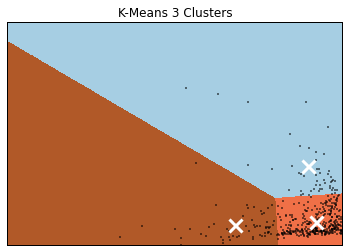

In [15]:
plotModel(clustersKM_3, clustersKM_3.cluster_centers_, 'K-Means 3 Clusters')

As we can see, in this case K-Means _underfits_. The topological criterion brings to a clear definition of a _low spending_ cluster. Meanwhile, as overall spending grows, the separation between the other two clusters might be less useful.

##K-Means 7 Clusters

In [16]:
clustersKM_7 = KMeans(n_clusters = 7)
clustersKM_7.fit(reduced_data)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=7, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

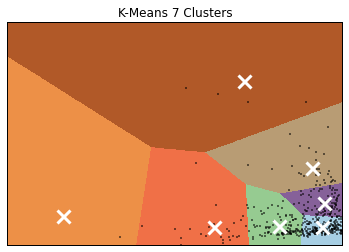

In [17]:
plotModel(clustersKM_7, clustersKM_7.cluster_centers_, 'K-Means 7 Clusters')

In this case we might be _overfitting_. We have too many clusters. Their separation might not be so meaningful given the context.

##GMM 2 Clusters

In [18]:
clustersGMM_2 = GMM(n_components=2)
clustersGMM_2.fit(reduced_data)

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

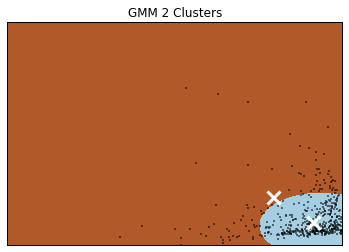

In [19]:
plotModel(clustersGMM_2, clustersGMM_2.means_, 'GMM 2 Clusters')

Even though this model might underfit, it shows the probabilistic criterion of GMM. We may interpret these two clusters as:
- customers who probably will spend as the mean or less
- customers who probably will spend above the mean

Anyway this simple model could be considered useful in case we just two classes. And will do better than K-Means.

##GMM 4 Clusters

In [20]:
clustersGMM_3 = GMM(n_components=3)
clustersGMM_3.fit(reduced_data)

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=3, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

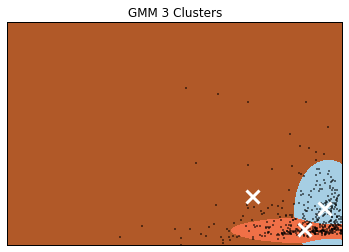

In [21]:
plotModel(clustersGMM_3, clustersGMM_3.means_, 'GMM 3 Clusters')

In this case we see two clusters significantly overlapping in the _low spending_ zone.
Samples classified as _Mostly Fresh_ at the lower right, will also have a significant probability in the _mostly non-Fresh_. 
This shows how soft decision boundaries works for this algorithm.

This model will not allow us to recognize an important cluster such as _low spending_.